In [45]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
import os

In [46]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
!pip install -q lime
import lime
import lime.lime_tabular

In [47]:
import shap
import lime
import lime.lime_tabular

In [48]:
os.listdir("/kaggle/input/")
df = pd.read_csv('/content/data.csv')
df.columns = [c.replace(' ', '_') for c in df.columns]

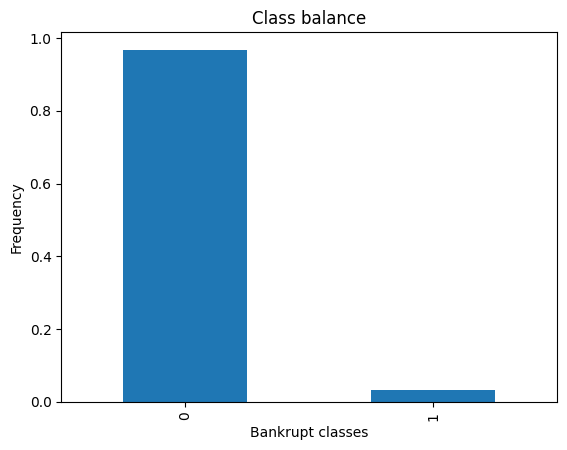

In [49]:
df['Bankrupt?'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel("Bankrupt classes")
plt.ylabel("Frequency")
plt.title("Class balance")
plt.show()

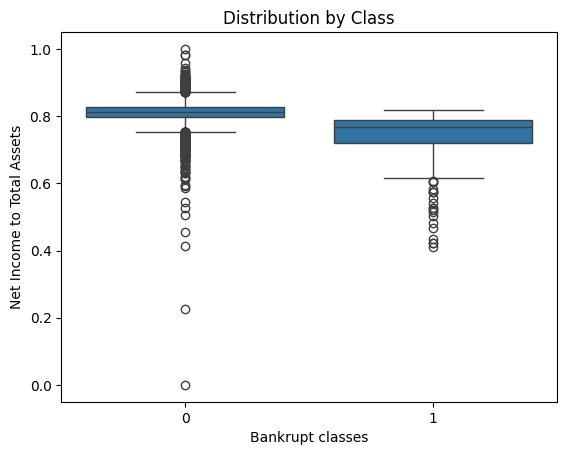

In [50]:

sns.boxplot(x="Bankrupt?", y="_Net_Income_to_Total_Assets", data=df)
plt.xlabel("Bankrupt classes")
plt.ylabel("Net Income to Total Assets")
plt.title("Distribution by Class")
plt.show()


In [51]:
target = "Bankrupt?"
X = df.drop(columns=[target])
y = df[target]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

In [54]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
sfm = SelectFromModel(rf_selector)
sfm.fit(X_train_over, y_train_over)

SelectFromModel(estimator=RandomForestClassifier(random_state=42))

In [55]:
selected_features = X.columns[sfm.get_support()]
print("Selected Features:", list(selected_features))

Selected Features: ['_ROA(C)_before_interest_and_depreciation_before_interest', '_ROA(A)_before_interest_and_%_after_tax', '_ROA(B)_before_interest_and_depreciation_after_tax', '_Pre-tax_net_Interest_Rate', '_After-tax_net_Interest_Rate', '_Non-industry_income_and_expenditure/revenue', '_Continuous_interest_rate_(after_tax)', '_Persistent_EPS_in_the_Last_Four_Seasons', '_Per_Share_Net_profit_before_tax_(Yuan_¥)', '_Net_Value_Growth_Rate', '_Quick_Ratio', '_Interest_Expense_Ratio', '_Total_debt/Total_net_worth', '_Debt_ratio_%', '_Net_worth/Assets', '_Borrowing_dependency', '_Net_profit_before_tax/Paid-in_capital', '_Current_Liabilities/Equity', '_Retained_Earnings_to_Total_Assets', '_Total_income/Total_expense', '_Current_Liability_to_Equity', '_Net_Income_to_Total_Assets', "_Net_Income_to_Stockholder's_Equity", '_Liability_to_Equity', '_Degree_of_Financial_Leverage_(DFL)', '_Interest_Coverage_Ratio_(Interest_expense_to_EBIT)', '_Equity_to_Liability']


In [56]:
X_train_selected = sfm.transform(X_train_over)
X_test_selected = sfm.transform(X_test)

In [57]:
nn = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
nn.fit(X_train_selected, y_train_over)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91      1313
           1       0.18      0.84      0.29        51

    accuracy                           0.85      1364
   macro avg       0.58      0.85      0.60      1364
weighted avg       0.96      0.85      0.89      1364



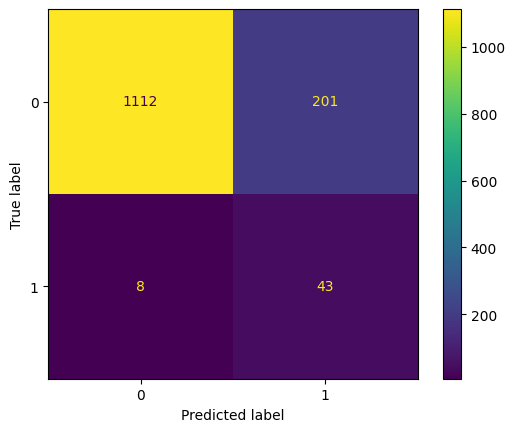

In [58]:
y_pred = nn.predict(X_test_selected)
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(nn, X_test_selected, y_test)
plt.show()


In [59]:
print("\n Permutation Importance:")
perm = permutation_importance(nn, X_test_selected, y_test, n_repeats=10, random_state=42)
for i in perm.importances_mean.argsort()[::-1]:
    print(f"{selected_features[i]}: {perm.importances_mean[i]:.4f}")


 Permutation Importance:
_Non-industry_income_and_expenditure/revenue: 0.0006
_Pre-tax_net_Interest_Rate: 0.0004
_Continuous_interest_rate_(after_tax): 0.0003
_Net_Income_to_Stockholder's_Equity: 0.0001
_After-tax_net_Interest_Rate: -0.0001
_Retained_Earnings_to_Total_Assets: -0.0001
_Total_income/Total_expense: -0.0004
_Interest_Coverage_Ratio_(Interest_expense_to_EBIT): -0.0007
_Interest_Expense_Ratio: -0.0008
_Borrowing_dependency: -0.0010
_Net_Value_Growth_Rate: -0.0010
_Liability_to_Equity: -0.0010
_Current_Liabilities/Equity: -0.0010
_Current_Liability_to_Equity: -0.0011
_Degree_of_Financial_Leverage_(DFL): -0.0021
_Total_debt/Total_net_worth: -0.0023
_Net_Income_to_Total_Assets: -0.0024
_Quick_Ratio: -0.0037
_Per_Share_Net_profit_before_tax_(Yuan_¥): -0.0059
_Net_profit_before_tax/Paid-in_capital: -0.0062
_Persistent_EPS_in_the_Last_Four_Seasons: -0.0064
_Net_worth/Assets: -0.0140
_ROA(C)_before_interest_and_depreciation_before_interest: -0.0147
_Equity_to_Liability: -0.0147
_R


### 1. Permutation Feature Importance

- **_Debt_ratio_%** came out as the top contributor, confirming the SHAP analysis.
- ROA variants and **_Equity_to_Liability** also had a strong effect.
- Several features showed near-zero or negative importance, indicating less or no value to the model.

**Conclusion:** The most critical predictors  **debt ratio** and **profitability ratios** consistently rank high, reinforcing their significance in determining financial health.

---

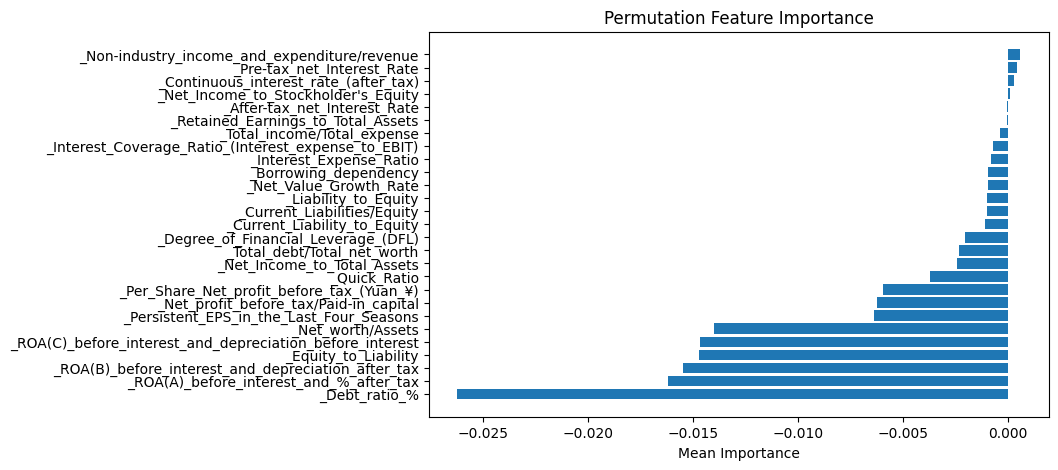

In [60]:
plt.figure(figsize=(8, 5))
plt.barh(range(len(selected_features)), perm.importances_mean[perm.importances_mean.argsort()])
plt.yticks(range(len(selected_features)), selected_features[perm.importances_mean.argsort()])
plt.title("Permutation Feature Importance")
plt.xlabel("Mean Importance")
plt.show()

### 2. Partial Dependence Plots (PDP)

- ROA(C)before_interest_and_depreciation_before_interestnand ROA(A)_before_interest and after_tax show a clear negative relationship with bankruptcy probability.
- As these profitability indicators increase, the model predicts lower bankruptcy risk.

**Conclusion:** Profitability metrics like ROA are crucial in reducing bankruptcy probability as they increase, risk decreases.

---


 PDP (Partial Dependence Plots):


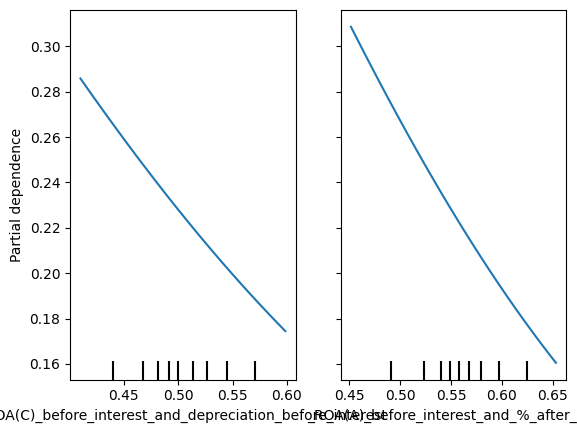

In [61]:
print("\n PDP (Partial Dependence Plots):")
top_pdp_features = list(selected_features[perm.importances_mean.argsort()[::-1][:2]])
PartialDependenceDisplay.from_estimator(nn, X_test_selected, features=[0, 1], feature_names=selected_features)
plt.show()

In [44]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_selected,
    feature_names=selected_features.tolist(),
    class_names=['Not Bankrupt', 'Bankrupt'],
    mode='classification'
)


# LIME Explanation :


The model was confident (88%) that the company is 'Not Bankrupt', with a 12% chance of being 'Bankrupt'.

Key contributing factors:
1. **ROA (Return on Assets)**: A high value of 0.50 significantly contributes to predicting financial stability.
2. **Quick Ratio**: A value of 0.01 (liquidity measure) indicates enough liquidity to avoid bankruptcy.
3. **Equity-to-Liability**: A value of 0.09 supports the company's financial stability.

Less influential factors:
1. **Net Value Growth Rate**: Has a negligible effect on the prediction.
2. **Net Profit Before Tax**: Minor contribution but still helps in indicating a stable financial condition.


In [62]:
i = 0
exp = explainer.explain_instance(X_test_selected[i], nn.predict_proba)
exp.show_in_notebook(show_table=True)

###  4.1 SHAP (Global Feature Importance)

- **_Debt_ratio_%** is the most impactful feature with a SHAP value of around **+0.17**.
- Other highly influential features include:
  - ROA(A) before_interest_and_%_after_tax**
  - ROA(B)b efore_interest_and_depreciation_after_tax**
  - ROA(C) before_interest_and_depreciation_before_interest**
- Additional contributors:
  -  Net_worth/Assets
  - Equity_to_Liability
  -  Persistent_EPS_in_the_Last_Four_Seasons

 Conclusion: The model heavily relies on the debt ratio and **profitability** (ROA variants) for predicting bankruptcy.

---

###  4.2 SHAP Waterfall (Local Explanation for One Instance)

- For a specific instance (company), the **Debt_ratio%** had the largest negative impact (~–0.4) on the prediction.
- Positive influences ( **_Net_profit_before_tax/Paid-in_capital**) were minor.


**Conclusion:** This company was predicted bankrupt primarily due to a high debt load and weak financial structure.

In [42]:
print("\n SHAP Explanation:")
explainer = shap.Explainer(nn.predict, X_train_selected, feature_names=selected_features.tolist())
shap_values = explainer(X_test_selected)




 SHAP Explanation:


PermutationExplainer explainer: 1365it [02:25,  9.25it/s]                          


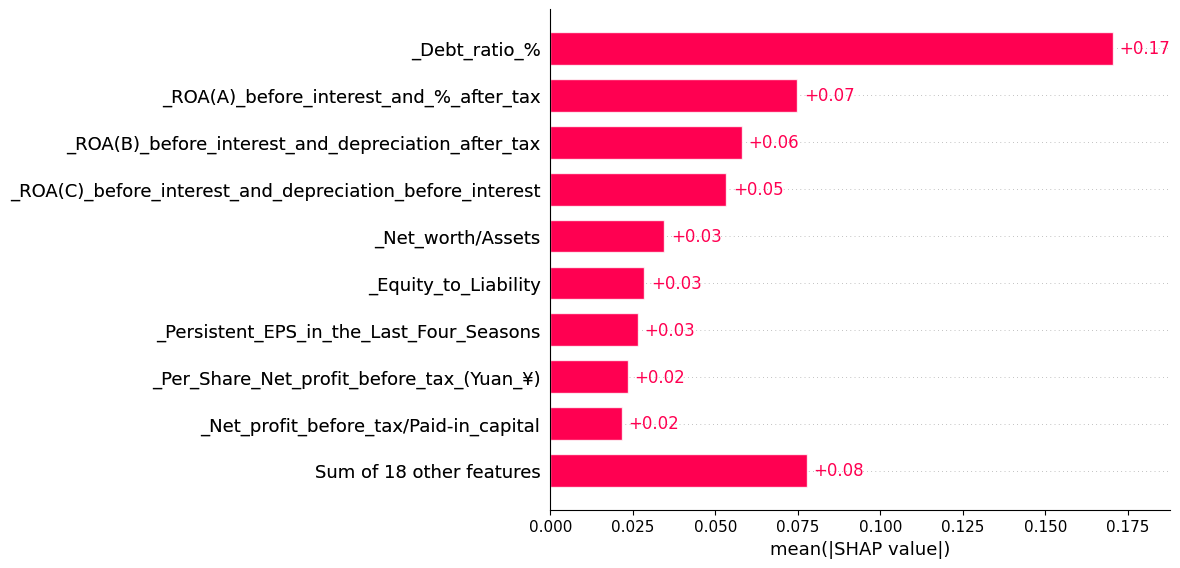

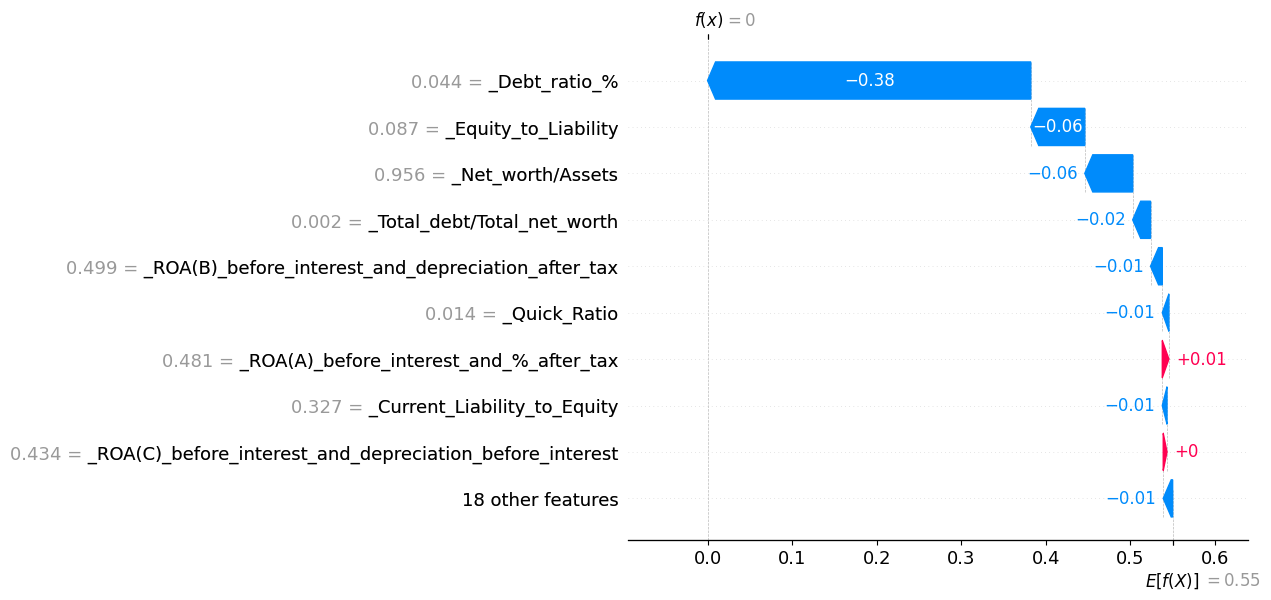

In [43]:

shap.plots.bar(shap_values)

shap.plots.waterfall(shap_values[0])